In [66]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

Load the dataset

In [67]:
ds1, ds2, ds3 = tfds.load('patch_camelyon:2.0.0',
                          split=['train[:10%]', 'test[:3%]', 'validation[:3%]'],
                          data_dir=r'/Users/emmahenneberggram/Documents/3. Semester/DS807 Anvendt Maskinlæring/Eksamen/',
                          download=False,
                          shuffle_files=True)

Konverterer en enkelt sample fra et datasæt til det format, der er nødvendigt for træning af en autoencoder.

In [68]:
def convert_sample(sample):
    image = sample['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Returner billedet som både input og label


Map and batch the datasets 

In [69]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

Autoencoder model

In [70]:
# Definer input-størrelsen
input_shape = (96, 96, 3)  # For PCam dataset
# Encoder
input_img = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

Forberede autoencoder modellen og summary af modellen

In [71]:
# Kompilér autoencoder-modellen
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Hvis du ønsker at se en oversigt over modellen, kan du tilføje:
autoencoder.summary()   # se output shape ( 12,12,16)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 64)        3692

Træning af autoencoder modellen med 10 epoch og earlystopping

In [72]:
history = autoencoder.fit(
    train_dataset, 
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
820/820 [==============================] - 1285s 2s/step - loss: 0.0157 - val_loss: 0.0113
Epoch 2/10
820/820 [==============================] - 1091s 1s/step - loss: 0.0100 - val_loss: 0.0096
Epoch 3/10
820/820 [==============================] - 1058s 1s/step - loss: 0.0085 - val_loss: 0.0084
Epoch 4/10
820/820 [==============================] - 1196s 1s/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
820/820 [==============================] - 1118s 1s/step - loss: 0.0072 - val_loss: 0.0072
Epoch 6/10
820/820 [==============================] - 1182s 1s/step - loss: 0.0068 - val_loss: 0.0069
Epoch 7/10
820/820 [==============================] - 948s 1s/step - loss: 0.0065 - val_loss: 0.0067
Epoch 8/10
820/820 [==============================] - 868s 1s/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/10
820/820 [==============================] - 696s 848ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 10/10
820/820 [==============================] - 482s 588ms/step - loss: 0.0

**Evaluering af Autoenkoderen**

Visualisering af Autoencoder Genopbygningsresultater med Matplotlib

1/1 [==============================] - 0s 396ms/step


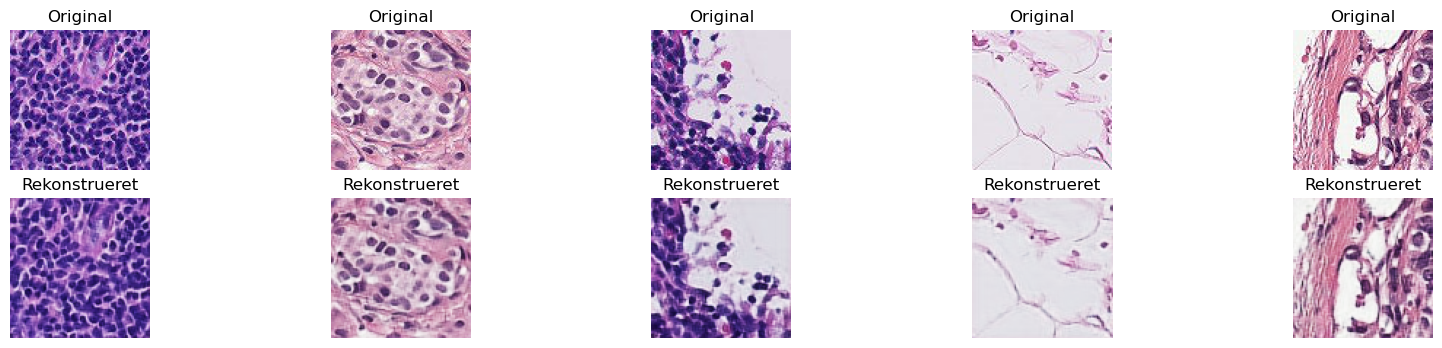

In [73]:
import matplotlib.pyplot as plt

def display_reconstructions(model, data, n_images=5):
    original_images = next(iter(data.take(1)))[0]  # Antager at data er et batch af billeder
    reconstructed_images = model.predict(original_images)

    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        # Vis originalbillede
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Vis rekonstrueret billede
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Rekonstrueret")
        plt.axis("off")
    plt.show()

# Kald funktionen med din autoenkoder og et datasæt
display_reconstructions(autoencoder, test_dataset)


**Beregning af Tab (Loss):**

Beregn tabet på testdatasættet for at få en kvantitativ vurdering af, hvor godt autoenkoderen rekonstruerer.

In [74]:
test_loss = autoencoder.evaluate(test_dataset)
print("Test Loss (MSE):", test_loss)


31/31 [==============================] - 7s 209ms/step - loss: 0.0057
Test Loss (MSE): 0.005709651857614517


Visualisering af trænings- og valideringstab

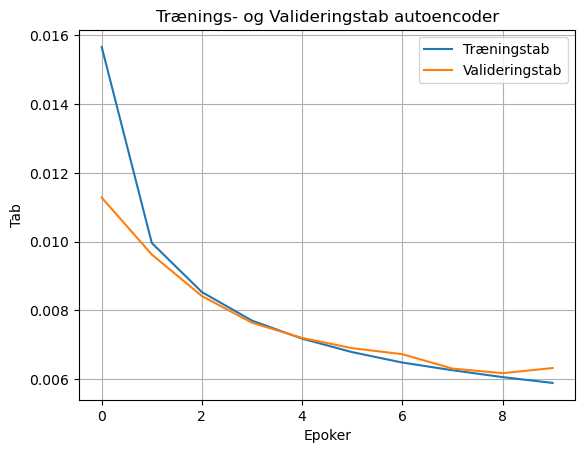

In [97]:
# Plot funktion for at visualisere trænings- og valideringstab
def plot_loss(history):
    plt.plot(history.history['loss'], label='Træningstab')
    plt.plot(history.history['val_loss'], label='Valideringstab')
    plt.title('Trænings- og Valideringstab autoencoder')
    plt.xlabel('Epoker')
    plt.ylabel('Tab')
    plt.legend()
    plt.grid(True)
    plt.show()

# Kald plottefunktionen
plot_loss(history)

Forberedelse af datasæt til klassifikation

In [75]:
def prepare_classification_dataset(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, depth=2)  # Da PCam er et binært klassifikationsproblem
    return image, label

Map og batch datasæt

In [76]:
train_dataset_cls = ds1.map(prepare_classification_dataset).batch(32)
validation_dataset_cls = ds3.map(prepare_classification_dataset).batch(32)
test_dataset_cls = ds2.map(prepare_classification_dataset).batch(32)


Skil data og labels ad

In [77]:
def extract_images_and_labels(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch)
        labels.append(label_batch)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

x_train, y_train = extract_images_and_labels(train_dataset_cls)
x_val, y_val = extract_images_and_labels(validation_dataset_cls)
x_test, y_test = extract_images_and_labels(test_dataset_cls)

Encoder-delen til klassifikation

In [78]:
encoder_for_classification = Model(input_img, encoded)

Tilføj klassifikationslag

In [79]:
x = Flatten()(encoded)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)  # Da PCam er et binært klassifikationsproblem

classification_model = Model(input_img, x)
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Træning af klassifikationsmodellen

In [80]:
CNNmodel = classification_model.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(x_val, y_val)  # Brug korrekt nøgleord her
)

Epoch 1/10


820/820 [==============================] - 215s 260ms/step - loss: 0.5471 - accuracy: 0.7558 - val_loss: 0.4767 - val_accuracy: 0.7782
Epoch 2/10
820/820 [==============================] - 185s 225ms/step - loss: 0.4309 - accuracy: 0.8060 - val_loss: 0.4659 - val_accuracy: 0.7823
Epoch 3/10
820/820 [==============================] - 189s 230ms/step - loss: 0.3526 - accuracy: 0.8507 - val_loss: 0.4850 - val_accuracy: 0.7986
Epoch 4/10
820/820 [==============================] - 189s 230ms/step - loss: 0.2686 - accuracy: 0.8898 - val_loss: 0.5203 - val_accuracy: 0.7854
Epoch 5/10
820/820 [==============================] - 187s 228ms/step - loss: 0.1884 - accuracy: 0.9282 - val_loss: 0.7185 - val_accuracy: 0.7854
Epoch 6/10
820/820 [==============================] - 180s 219ms/step - loss: 0.1186 - accuracy: 0.9577 - val_loss: 0.8762 - val_accuracy: 0.7558
Epoch 7/10
820/820 [==============================] - 181s 220ms/step - loss: 0.0697 - accuracy: 0.9771 - val_loss: 1.1324 - val_accura

**Evaluering af Klassifikationsmodellen**

Nøjagtigheds- og Tabshistorik:

Plot nøjagtighed og tab over trænings- og valideringsdatasættene.

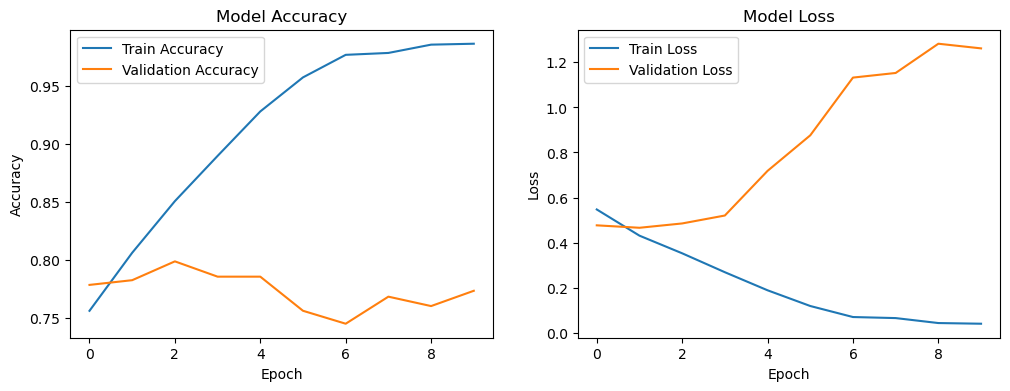

In [81]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot træningsnøjagtighed og valideringsnøjagtighed
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot træningstab og valideringstab
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Kald plot_history med træningshistorikken
plot_history(CNNmodel)


**Forvirringsmatrix:**

En forvirringsmatrix er en nyttig måde at se, hvordan din model præsterer på tværs af forskellige klasser.

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

Plot af confusionmatrix på testdata

31/31 [==============================] - 3s 92ms/step


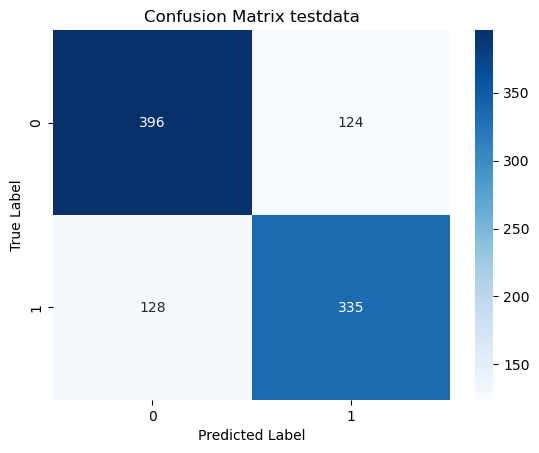

In [91]:
def plot_confusion_matrix(model, x_data, y_true):
    # Konverter til numpy arrays hvis det er tensors
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()
    if isinstance(x_data, tf.Tensor):
        x_data = x_data.numpy()

    # Forudsige og konvertere til klasseetiketter
    y_pred = model.predict(x_data).argmax(axis=1)

    # Tjekker om y_true er one-hot encoded og konverterer hvis nødvendigt
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true_labels = y_true.argmax(axis=1)
    else:
        y_true_labels = y_true

    # Beregn confusion matrix
    conf_mat = confusion_matrix(y_true_labels, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix testdata')  # Tilføj overskrift her
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Anvend funktionen med testdata
plot_confusion_matrix(classification_model, x_test, y_test)


Plot af confusionmatrix på valideringsdata

31/31 [==============================] - 3s 90ms/step


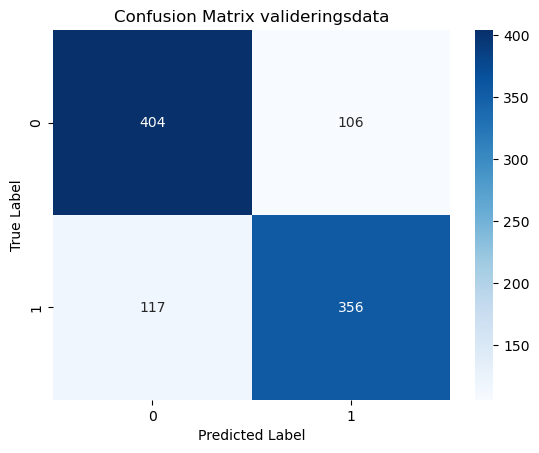

In [95]:
# Funktion til at visualisere confusion matrix
def plot_confusion_matrix(model, x_data, y_true):
    # Tjek at dataene er tensors, og kør .numpy() for at konvertere til numpy arrays
    if isinstance(y_true, tf.Tensor):
        y_true = y_true.numpy()
    if isinstance(x_data, tf.Tensor):
        x_data = x_data.numpy()

    y_pred = model.predict(x_data).argmax(axis=1)
    y_true_labels = y_true.argmax(axis=1)
    conf_mat = confusion_matrix(y_true_labels, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix valideringsdata')  # Tilføj overskrift her
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Forudsat at x_val og y_val allerede er indlæst som NumPy arrays eller TensorFlow tensors
plot_confusion_matrix(classification_model, x_val, y_val)

Evaluering af Modelydelse ved brug af ROC Kurve og AUC-værdi

31/31 [==============================] - 4s 127ms/step


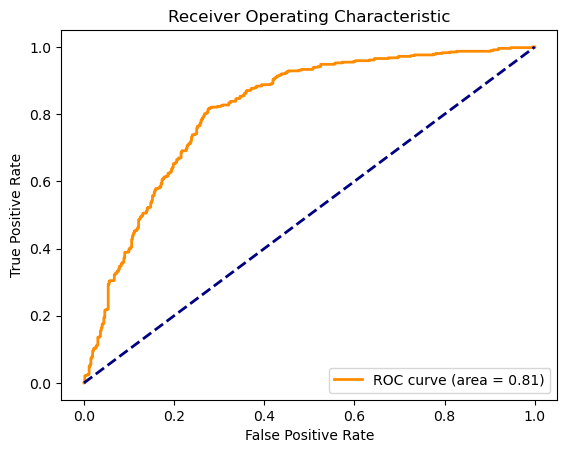

In [93]:
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt

y_pred_prob = classification_model.predict(x_test)[:, 1]  # Forudsigelse af sandsynligheder for klasse 1

# Brug tf.argmax til TensorFlow tensors og konverter til numpy array
y_true = tf.argmax(y_test, axis=1).numpy()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [94]:
from sklearn.metrics import classification_report
import tensorflow as tf

y_pred = classification_model.predict(x_test).argmax(axis=1)
y_true = tf.argmax(y_test, axis=1)  # Brug tf.argmax til TensorFlow tensors
y_true = y_true.numpy()  # Konverter til numpy array, hvis nødvendigt for sklearn funktioner

print(classification_report(y_true, y_pred))

31/31 [==============================] - 4s 131ms/step
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       520
           1       0.73      0.72      0.73       463

    accuracy                           0.74       983
   macro avg       0.74      0.74      0.74       983
weighted avg       0.74      0.74      0.74       983

